In [1]:
%matplotlib inline

import re, itertools, getpass, pymysql.cursors
from collections import Counter
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy.stats import ttest_ind, pearsonr, spearmanr



In [2]:
def ExecuteQuery(Connector, SQLQuery):

    Cursor = Connector.cursor()
    Cursor.execute(SQLQuery)
    Connector.commit()
    
    ReturnedRows = []

    while True:
        Row = Cursor.fetchone()
        if Row is None:
            break
        else:
            ReturnedRows.append(Row)

    return ReturnedRows

In [3]:
#  Forum_Events                       |
#| Forum_Info                         |
#| Problem_Events_with_Info           |
#| User_Grade                   |
#| User_Location                      |
#| Video_Events                       |
#| Video_Info   

In [4]:
Connector = pymysql.connect(user='hplearn', password=getpass.getpass("Password: "), host='cedegemac8.epfl.ch', port=3306, charset='utf8mb4', use_unicode=True)


Password: ········


In [5]:
# Select 1 target course
CourseID = 'progfun-2012-001' # Principles of Reactive Programming

# Fetch grade history of students who took selected course
Output = ExecuteQuery(Connector, """
    SELECT *
    FROM project_how_people_learn.problem_events_with_info
    WHERE CourseID='%s'
""" % CourseID)

# Convert output to dataframe
VideoEventsDF = pd.DataFrame(Output, columns=['CourseID', 'UserID', 'TimeStamp', 'EventType', 'ProblemType', 'ProblemID', 'SubmissionNumber', 'Grade', 'MaximumSubmissions', 'title', 'openTime', 'SoftCloseTime', 'HardCloseTime'])

# Display size and head of dataframe
print(len(VideoEventsDF))


757606


### Let's try to findout the difference between hard and soft deadlines

In [89]:
submissions = VideoEventsDF[VideoEventsDF['ProblemType'] == 'Assignment']

In [90]:
submissions.head(1)

,CourseID,UserID,TimeStamp,EventType,ProblemType,ProblemID,SubmissionNumber,Grade,MaximumSubmissions,title,openTime,SoftCloseTime,HardCloseTime
7,progfun-2012-001,1363859                                       ...,1350002205,Problem.Check,Assignment,14                              ,6,98.500004,0.0,Huffman Coding / Huffman Coding,1.349793e+09,1.351235e+09,1.351584e+09


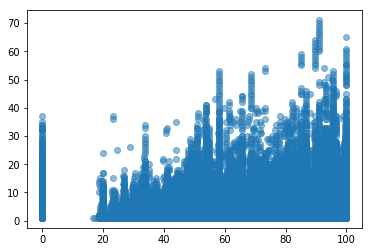

In [91]:
plt.scatter(submissions['Grade'], submissions['SubmissionNumber'], alpha=.5)

In [92]:
submissions.head(1)

,CourseID,UserID,TimeStamp,EventType,ProblemType,ProblemID,SubmissionNumber,Grade,MaximumSubmissions,title,openTime,SoftCloseTime,HardCloseTime
7,progfun-2012-001,1363859                                       ...,1350002205,Problem.Check,Assignment,14                              ,6,98.500004,0.0,Huffman Coding / Huffman Coding,1.349793e+09,1.351235e+09,1.351584e+09


Submissions before and after soft deadline

In [93]:
len(submissions[submissions['Grade'].isnull()])

182

Removing NaN grades

In [94]:
submissions = submissions.dropna(subset=['Grade'])

In [95]:
early_submissions = submissions[submissions['TimeStamp'] < submissions['SoftCloseTime']]
late_submissions = submissions[submissions['TimeStamp'] >= submissions['SoftCloseTime']]

In [96]:
wtf_submissions = submissions[submissions['TimeStamp'] > submissions['HardCloseTime']]

In [97]:
print(len(early_submissions))
print(len(late_submissions))

206680
27491


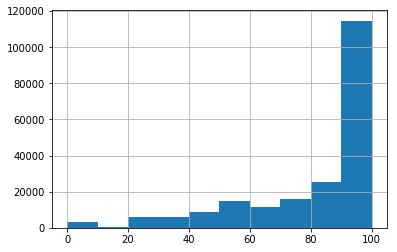

In [98]:
early_submissions['Grade'].hist()

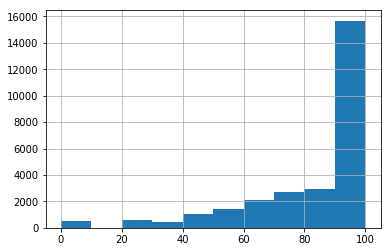

In [99]:
late_submissions['Grade'].hist()

In [100]:
early_submissions['Grade'].describe()

count    206680.000000
mean         81.816785
std          23.737889
min           0.000000
25%          70.300002
50%          93.299999
75%         100.000000
max         100.000000
Name: Grade, dtype: float64

In [101]:
late_submissions['Grade'].describe()

count    27491.000000
mean        82.934913
std         22.685194
min          0.000000
25%         72.199998
50%         93.299999
75%        100.000000
max        100.000000
Name: Grade, dtype: float64

In [102]:
ttest_ind(early_submissions['Grade'], late_submissions['Grade'])

Ttest_indResult(statistic=-7.374789688896361, pvalue=1.6514426822983696e-13)

We cannot reject the hypothesis that they're similar, p = 1.6e-13...

In [103]:
submissions.head(2)

,CourseID,UserID,TimeStamp,EventType,ProblemType,ProblemID,SubmissionNumber,Grade,MaximumSubmissions,title,openTime,SoftCloseTime,HardCloseTime
7,progfun-2012-001,1363859                                       ...,1350002205,Problem.Check,Assignment,14                              ,6,98.500004,0.0,Huffman Coding / Huffman Coding,1.349793e+09,1.351235e+09,1.351584e+09
9,progfun-2012-001,79240                                         ...,1350920280,Problem.Check,Assignment,12                              ,1,92.700005,0.0,Object-Oriented Sets / Object-Oriented Sets,1.349177e+09,1.350025e+09,1.350371e+09


## Measuring motivation

We'll try to measure motivation by using the submissions patterns as a proxy for motivation

In [104]:
len(submissions)

234171

In [105]:
len(submissions[(submissions['TimeStamp'] - submissions['openTime']) < 0])

38899

Deleting submission that were made before the homework was released. (how is that even possible ?)

In [106]:
submissions = submissions[(submissions['TimeStamp'] - submissions['openTime']) >= 0]

Casting the numbers to int (was string before)

In [107]:
submissions['UserID'] = pd.to_numeric(submissions['UserID'].str.strip('\0'))
submissions['ProblemID'] = pd.to_numeric(submissions['ProblemID'].str.strip('\0'))

Delete the example assignments. It is not mandatory and not graded

In [108]:
submissions = submissions[submissions['ProblemID'] != 5]

In [109]:
len(submissions)

174507

We'll now first try to get the last submission of each user and keep its 'earliness'

In [110]:
latest_submission = submissions.sort_values('TimeStamp', ascending=False).groupby(['UserID', 'ProblemID']).first().reset_index()


Let's compare the user that finished the Mooc and the others

In [111]:
numberProblems = len(submissions['ProblemID'].unique())
numberProblems

6

List of the users that submitted all the exercices

In [112]:
count_submissions = submissions[['UserID', 'ProblemID']].groupby('UserID').agg({'ProblemID' : 'nunique'}).reset_index()
count_submissions = count_submissions.rename(columns={'ProblemID': 'count'})[['UserID', 'count']]

In [113]:
count_submissions.head()

,UserID,count
0,964,4
1,1157,4
2,1568,3
3,1572,4
4,1584,3


In [114]:
len(count_submissions)

16400

Number of user that submitted the 7 assignements

In [115]:
(count_submissions['count'] >= numberProblems).sum()

2313

In [116]:
user_all_submission = count_submissions[count_submissions['count'] >= numberProblems]['UserID']

In [117]:
len(user_all_submission)

2313

#### Compute average date per user and per homework

In [118]:
average_ts_user = submissions.groupby(['UserID', 'ProblemID']).agg({'TimeStamp' : 'mean'}).rename(columns={'TimeStamp' : 'AvgTimeStamp'}).reset_index()

In [119]:
average_ts_user.head()

,UserID,ProblemID,AvgTimeStamp
0,964,12,1.349747e+09
1,964,14,1.349860e+09
2,964,17,1.351038e+09
3,964,20,1.351680e+09
4,1157,12,1.349393e+09


The softclosetime are hopefully unique

In [120]:
submissions[['ProblemID', 'SoftCloseTime']].groupby(['ProblemID']).nunique()

,ProblemID,SoftCloseTime
ProblemID,,
6,1,1
7,1,1
12,1,1
14,1,1
17,1,1
20,1,1


In [121]:
softCloseTime_problem = submissions[['ProblemID', 'SoftCloseTime', 'HardCloseTime', 'openTime']].drop_duplicates()

In [122]:
softCloseTime_problem

,ProblemID,SoftCloseTime,HardCloseTime,openTime
7,14,1.351235e+09,1.351584e+09,1.349793e+09
9,12,1.350025e+09,1.350371e+09,1.349177e+09
23,17,1.352063e+09,1.352408e+09,1.351019e+09
24,20,1.353272e+09,1.353618e+09,1.351643e+09
39,6,1.349420e+09,1.349766e+09,1.349090e+09
116,7,1.348816e+09,1.349161e+09,1.348718e+09


In [123]:
softCloseTime_problem['HardCloseTime'] - softCloseTime_problem['SoftCloseTime']

7      349200.0
9      345600.0
23     345600.0
24     345600.0
39     345600.0
116    345600.0
dtype: float64

In [124]:
average_ts_with_softclose = average_ts_user.merge(softCloseTime_problem, on='ProblemID')
score_per_user_problem = average_ts_with_softclose.copy()
score_per_user_problem['lateness'] = score_per_user_problem['AvgTimeStamp'] - score_per_user_problem['SoftCloseTime']
score_per_user_problem['lateness_norm'] = score_per_user_problem['lateness'] / (score_per_user_problem['HardCloseTime'] - score_per_user_problem['openTime']) 


In [125]:
score_per_user_problem.head()

,UserID,ProblemID,AvgTimeStamp,SoftCloseTime,HardCloseTime,openTime,lateness,lateness_norm
0,964,12,1.349747e+09,1.350025e+09,1.350371e+09,1.349177e+09,-277908.0,-0.232800
1,1157,12,1.349393e+09,1.350025e+09,1.350371e+09,1.349177e+09,-631847.0,-0.529291
2,1568,12,1.350024e+09,1.350025e+09,1.350371e+09,1.349177e+09,-1262.0,-0.001057
3,1572,12,1.349748e+09,1.350025e+09,1.350371e+09,1.349177e+09,-277373.0,-0.232352
4,1584,12,1.350128e+09,1.350025e+09,1.350371e+09,1.349177e+09,102979.0,0.086264


In [126]:
accumulated_lateness_per_user = score_per_user_problem.groupby('UserID', as_index=False).sum()[['UserID', 'lateness', 'lateness_norm']]


In [127]:
average_lateness_per_user = score_per_user_problem.groupby('UserID', as_index=False).mean()[['UserID', 'lateness', 'lateness_norm']]


Only keeping user with all the 6 submissions

In [128]:
accumulated_lateness_per_user_all = accumulated_lateness_per_user[accumulated_lateness_per_user['UserID'].isin(user_all_submission)]


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12cbc79e8>]],
      dtype=object)

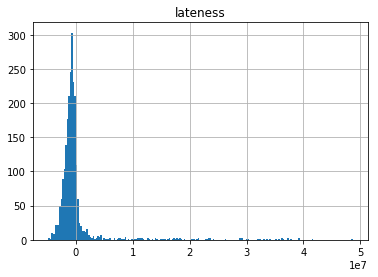

In [170]:
accumulated_lateness_per_user_all.hist('lateness', bins=200)


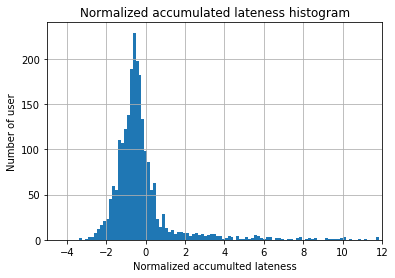

In [193]:
accumulated_lateness_per_user_all.hist('lateness_norm', bins=400)
plt.title('Normalized accumulated lateness histogram')
plt.xlabel('Normalized accumulted lateness')
plt.ylabel('Number of user')
plt.xlim(-5, 12)
plt.savefig('./tim_graph/accumulated_lateness_per_user_all_norm.png', dpi=250)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1394b6e10>]],
      dtype=object)

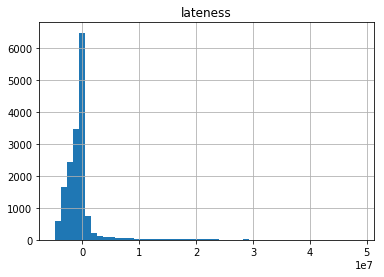

In [131]:
accumulated_lateness_per_user.hist('lateness', bins=50)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13cc7a668>]],
      dtype=object)

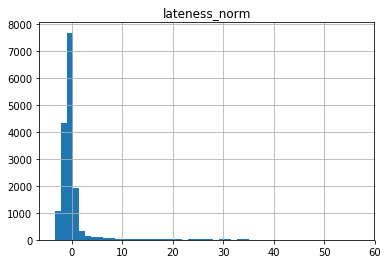

In [132]:
accumulated_lateness_per_user.hist('lateness_norm', bins=50)

#### Getting the course grade of each user

In [133]:
CourseID = 'progfun-2012-001' 

# Fetch grade history of students who took selected course
Output = ExecuteQuery(Connector, """
    SELECT * 
    FROM project_how_people_learn.user_grades
    WHERE CourseID='%s'
""" % CourseID)

# Convert output to dataframe
grade_df = pd.DataFrame(Output, columns=['CourseID', 'UserID', 'Grade', 'AchievementLevel', 'Distinction'])

# Display size and head of dataframe
print(len(grade_df))


53271


In [134]:
grade_df['UserID'] = pd.to_numeric(grade_df['UserID'].str.strip('\0'))

In [135]:
grade_df = grade_df[['UserID', 'Grade', 'AchievementLevel']]

In [136]:
merged = accumulated_lateness_per_user_all.merge(grade_df, on='UserID')

In [137]:
merged.corr('pearson')

,UserID,lateness,lateness_norm,Grade
UserID,1.000000,0.124738,0.146602,-0.144622
lateness,0.124738,1.000000,0.979622,-0.700931
lateness_norm,0.146602,0.979622,1.000000,-0.713592
Grade,-0.144622,-0.700931,-0.713592,1.000000


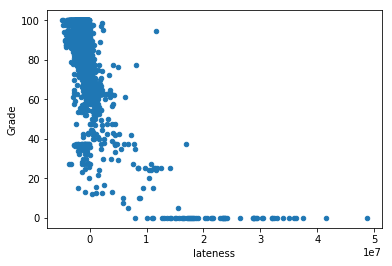

In [138]:
merged.plot.scatter('lateness', 'Grade')

If we remove the user with 0 as a score

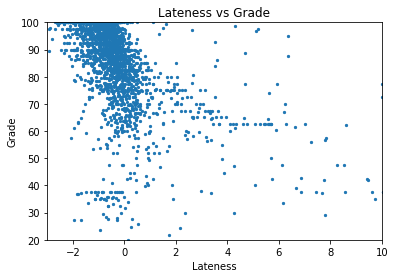

In [254]:
merged[merged['Grade'] != 0].plot.scatter('lateness_norm', 'Grade', s=5)
plt.xlim(-3,10)
plt.ylim(20,100)
plt.xlabel('Lateness')
plt.ylabel('Grade')
plt.title('Lateness vs Grade')
plt.savefig('./tim_graph/late_grade.png', dpi=250)

In [140]:
merged[merged['Grade'] != 0].corr("pearson")

,UserID,lateness,lateness_norm,Grade
UserID,1.000000,0.036286,0.091484,-0.087453
lateness,0.036286,1.000000,0.920090,-0.569064
lateness_norm,0.091484,0.920090,1.000000,-0.575046
Grade,-0.087453,-0.569064,-0.575046,1.000000


In [141]:
merged[merged['Grade'] != 0].corr("spearman")

,UserID,lateness,lateness_norm,Grade
UserID,1.000000,-0.012774,0.049986,-0.123755
lateness,-0.012774,1.000000,0.892953,-0.498202
lateness_norm,0.049986,0.892953,1.000000,-0.593790
Grade,-0.123755,-0.498202,-0.593790,1.000000


In [190]:
spearmanr(merged[merged['Grade'] != 0]['lateness_norm'], merged[merged['Grade'] != 0]['Grade'])

SpearmanrResult(correlation=-0.5937902642889087, pvalue=3.188066382208086e-214)

In [191]:
pearsonr(merged[merged['Grade'] != 0]['lateness_norm'], merged[merged['Grade'] != 0]['Grade'])

(-0.5750458529084993, 5.518043026565287e-198)

Strong correlation.

Let's have a look at the lateness of people passing the class and the one that didn't pass

In [142]:
user_pass = merged[merged['AchievementLevel'] == 'Passed']
user_not_pass = merged[merged['AchievementLevel'] == 'Failed']

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x13d5cbc18>]],
      dtype=object)

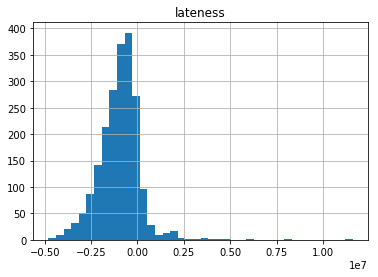

In [143]:
user_pass.hist('lateness', bins=40)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14adaeac8>]],
      dtype=object)

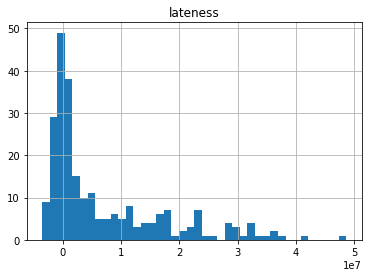

In [144]:
user_not_pass.hist('lateness', bins=40)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14af68630>]],
      dtype=object)

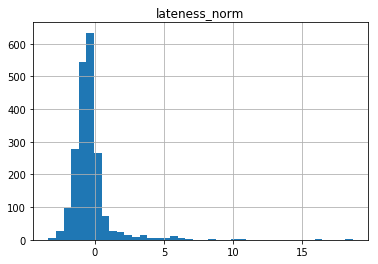

In [145]:
user_pass.hist('lateness_norm', bins=40)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x14b031fd0>]],
      dtype=object)

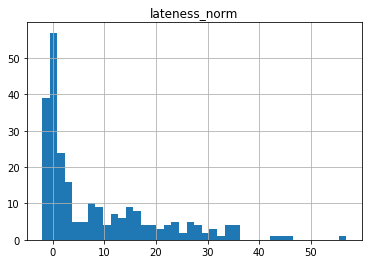

In [146]:
user_not_pass.hist('lateness_norm', bins=40)

In [147]:
ttest_ind(user_not_pass['lateness'], user_pass['lateness'])

Ttest_indResult(statistic=32.169965856360356, pvalue=7.508439927016018e-188)

In [148]:
print(len(user_pass))
print(len(user_not_pass))

2057
248


We can see that in the population of the user that submitted the 7 assignements but didn't pass the class, there is a big shift to the right in lateness => they didn't submit the assignement on time

We'll know have a look between the lateness of the people passing the class with an average of >80% and less than 80%

In [331]:
user_pass_g_80 = user_pass[user_pass['Grade'] >= 90]
user_pass_l_80 = user_pass[user_pass['Grade'] < 90]

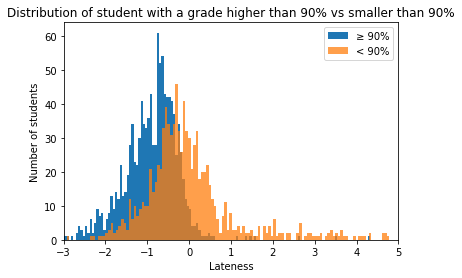

In [354]:
plt.hist(user_pass_g_80['lateness_norm'], bins=350, alpha=1, label='≥ 90%')
plt.hist(user_pass_l_80['lateness_norm'], bins=350, alpha=.75, label='< 90%')
plt.xlim(-3, 5)
plt.title('Distribution of student with a grade higher than 90% vs smaller than 90%')
plt.xlabel('Lateness')
plt.ylabel('Number of students')
plt.legend(loc='upper right')
plt.savefig('./tim_graph/grade90_lateness.png', dpi=250)
plt.show()

(-3, 3)

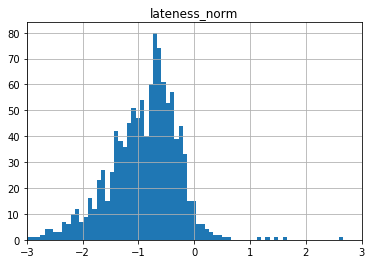

In [333]:
user_pass_g_80.hist('lateness_norm', bins=250)
plt.xlim(-3,3)

(-3, 3)

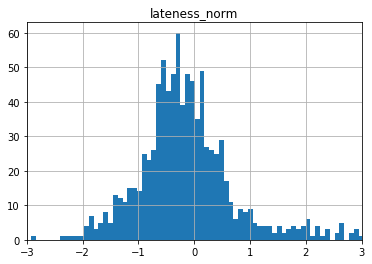

In [334]:
user_pass_l_80.hist('lateness_norm', bins=250)
plt.xlim(-3,3)

In [335]:
ttest_ind(user_pass_l_80['lateness_norm'], user_pass_g_80['lateness_norm'])

Ttest_indResult(statistic=18.082236283932836, pvalue=6.13773065023623e-68)

In [336]:
user_pass_g_80.describe()

,UserID,lateness,lateness_norm,Grade
count,1.111000e+03,1.111000e+03,1111.000000,1111.000000
mean,8.852854e+05,-1.330668e+06,-0.864690,96.696917
std,5.481643e+05,9.806412e+05,0.889235,3.302903
min,1.641000e+03,-4.799645e+06,-3.377674,90.000000
25%,3.065045e+05,-1.854999e+06,-1.271205,94.356250
50%,1.081157e+06,-1.193776e+06,-0.802034,97.500000
75%,1.356689e+06,-6.913209e+05,-0.482929,100.000000
max,1.542593e+06,1.160256e+07,16.003840,100.000000


In [337]:
user_pass_l_80.describe()

,UserID,lateness,lateness_norm,Grade
count,9.460000e+02,9.460000e+02,946.000000,946.000000
mean,9.697824e+05,-5.694595e+05,0.169331,78.578433
std,5.587352e+05,1.140926e+06,1.644544,8.358109
min,1.701000e+03,-4.239429e+06,-2.924353,59.925000
25%,4.750108e+05,-1.115718e+06,-0.594131,72.500000
50%,1.246350e+06,-5.213085e+05,-0.174292,80.000000
75%,1.433078e+06,-2.686131e+04,0.355315,85.722500
max,1.691646e+06,8.156821e+06,18.659620,89.995000


In [338]:
len(user_pass_g_80)

1111

In [339]:
len(user_pass_l_80)

946

We observe the same phenomena

In [155]:
t = submissions[['ProblemID', 'openTime', 'SoftCloseTime', 'HardCloseTime']].drop_duplicates()
t

,ProblemID,openTime,SoftCloseTime,HardCloseTime
7,14,1.349793e+09,1.351235e+09,1.351584e+09
9,12,1.349177e+09,1.350025e+09,1.350371e+09
23,17,1.351019e+09,1.352063e+09,1.352408e+09
24,20,1.351643e+09,1.353272e+09,1.353618e+09
39,6,1.349090e+09,1.349420e+09,1.349766e+09
116,7,1.348718e+09,1.348816e+09,1.349161e+09


### Compare lateness of user that dropped the class with the one that passed

A user that dropped the class is defined as a user that doesn't submit all assignements but submitted at least one

In [156]:
user_not_all_submission = count_submissions[(count_submissions['count'] < numberProblems)]['UserID']


In [157]:
average_lateness_per_user_not_all = average_lateness_per_user[average_lateness_per_user['UserID'].isin(user_not_all_submission)]
average_lateness_per_user_all = average_lateness_per_user[average_lateness_per_user['UserID'].isin(user_all_submission)]


In [158]:
len(user_not_all_submission)

14087

In [159]:
len(user_all_submission)

2313

In [160]:
ttest_ind(average_lateness_per_user_all['lateness_norm'], average_lateness_per_user_not_all['lateness_norm'])

Ttest_indResult(statistic=-3.7573032518308396, pvalue=0.00017234916450560998)

In [161]:
average_lateness_per_user_all.describe()

,UserID,lateness,lateness_norm
count,2.313000e+03,2.313000e+03,2313.000000
mean,9.477666e+05,-2.532948e+03,0.116541
std,5.683309e+05,8.077415e+05,0.898230
min,1.641000e+03,-7.999408e+05,-0.562946
25%,3.880780e+05,-2.530285e+05,-0.162426
50%,1.195926e+06,-1.327740e+05,-0.083914
75%,1.405185e+06,-3.570142e+04,0.005988
max,2.088243e+06,8.109404e+06,9.483495


In [162]:
average_lateness_per_user_not_all.describe()

,UserID,lateness,lateness_norm
count,1.408700e+04,1.408700e+04,14087.000000
mean,8.353073e+05,-1.823619e+04,0.283344
std,5.371412e+05,1.219790e+06,2.103794
min,9.640000e+02,-1.315114e+06,-0.763666
25%,2.382095e+05,-4.914481e+05,-0.333542
50%,8.887240e+05,-1.635383e+05,-0.140077
75%,1.338060e+06,1.500000e+04,0.030067
max,2.127600e+06,1.308694e+07,29.499414


(-1, 3)

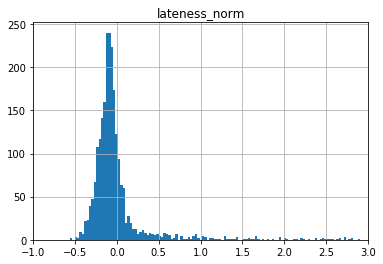

In [343]:
average_lateness_per_user_all.hist('lateness_norm', bins=350)
plt.xlim(-1, 3)

(-1, 3)

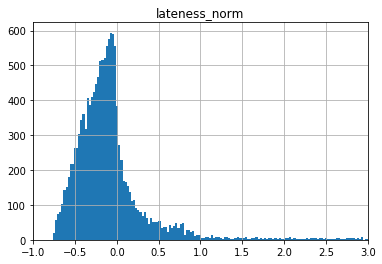

In [350]:
average_lateness_per_user_not_all.hist('lateness_norm', bins=1200)
plt.xlim(-1, 3)

In [165]:
len(user_all_submission)

2313

In [166]:
average_lateness_per_user.merge(grade_df, on="UserID").corr()

,UserID,lateness,lateness_norm,Grade
UserID,1.000000,0.105778,0.101918,-0.039077
lateness,0.105778,1.000000,0.953235,-0.528635
lateness_norm,0.101918,0.953235,1.000000,-0.424376
Grade,-0.039077,-0.528635,-0.424376,1.000000


In [167]:
average_lateness_per_user_all.describe()

,UserID,lateness,lateness_norm
count,2.313000e+03,2.313000e+03,2313.000000
mean,9.477666e+05,-2.532948e+03,0.116541
std,5.683309e+05,8.077415e+05,0.898230
min,1.641000e+03,-7.999408e+05,-0.562946
25%,3.880780e+05,-2.530285e+05,-0.162426
50%,1.195926e+06,-1.327740e+05,-0.083914
75%,1.405185e+06,-3.570142e+04,0.005988
max,2.088243e+06,8.109404e+06,9.483495


In [168]:
average_lateness_per_user_not_all.describe()

,UserID,lateness,lateness_norm
count,1.408700e+04,1.408700e+04,14087.000000
mean,8.353073e+05,-1.823619e+04,0.283344
std,5.371412e+05,1.219790e+06,2.103794
min,9.640000e+02,-1.315114e+06,-0.763666
25%,2.382095e+05,-4.914481e+05,-0.333542
50%,8.887240e+05,-1.635383e+05,-0.140077
75%,1.338060e+06,1.500000e+04,0.030067
max,2.127600e+06,1.308694e+07,29.499414


In [246]:
grade_df.head()

,UserID,Grade,AchievementLevel
0,1,0.0000,Failed
1,1000012,79.6975,Passed
2,100002,0.0000,Failed
3,100009,0.0000,Failed
4,1000116,0.0000,Failed


In [245]:
grade_df[grade_df['AchievementLevel'] == 'Passed']['Grade'].describe()

count    9593.000000
mean       91.335596
std        11.866047
min        59.925000
25%        85.020000
50%        98.050000
75%       100.000000
max       100.000000
Name: Grade, dtype: float64